<a href="https://colab.research.google.com/github/TinkerTechie/Gen-Ai-/blob/main/NLP_%26_RNN_C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Step 1: Import the Libraries
We'll need `sentence-transformers` to turn our text into high-quality vectors.

In [ ]:
# Install the library if you haven't already
# !pip install sentence-transformers

import pandas as pd
import numpy as np
import re
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from textblob import TextBlob
from sentence_transformers import SentenceTransformer

In [ ]:
data = pd.read_csv('/content/email_spam_dataset_10000_samples.csv')
data.head()

,email_text,label
0,Please review the attached document.,ham
1,Earn ₹31804 weekly from home. Register now.,spam
2,Your account was selected for a special reward...,spam
3,Limited offer! Save 66% on your purchase today.,spam
4,Free gift card worth ₹95964. Claim before expiry.,spam


In [ ]:
data.shape

(10000, 2)

In [ ]:
data['label'].value_counts()

,count
label,
spam,5281
ham,4719


### Step 2: Load and Clean Data
Same as before, we clean out the trash so the AI can focus on the words.

In [ ]:
# We will iterate through each email and clean it
def clean_simple(text):
    text = str(text).lower()
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    return text

'''
apply() - method used to apply a user defined function on a
data column
'''
data['cleaned_text'] = data['email_text'].apply(clean_simple)
data['label_num'] = data['label'].map({'spam': 1, 'ham': 0})

print("Data Loaded and Cleaned!")
data.head()

Data Loaded and Cleaned!


,email_text,label,cleaned_text,label_num
0,Please review the attached document.,ham,please review the attached document,0
1,Earn ₹31804 weekly from home. Register now.,spam,earn weekly from home register now,1
2,Your account was selected for a special reward...,spam,your account was selected for a special reward...,1
3,Limited offer! Save 66% on your purchase today.,spam,limited offer save on your purchase today,1
4,Free gift card worth ₹95964. Claim before expiry.,spam,free gift card worth claim before expiry,1


In [ ]:
clean_simple('abcde!!!@@^^^***xyz')

'abcdexyz'

### Step 3: Embed Once! (The DNA of Language)
We use the `all-MiniLM-L6-v2` model to transform every email into a 384-dimensional vector. This vector captures the *meaning* of the entire email.

In [ ]:
# 1. Download the Pre-trained Brain
embed_model = SentenceTransformer('all-MiniLM-L6-v2')

# 2. Convert all emails to embeddings
print("Generating Embeddings (This might take a moment...)")
embeddings = embed_model.encode(data['cleaned_text'].tolist())

print(f"Embeddings Generated! Shape: {embeddings.shape}")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/103 [00:00<?, ?it/s]

BertModel LOAD REPORT from: sentence-transformers/all-MiniLM-L6-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Generating Embeddings (This might take a moment...)
Embeddings Generated! Shape: (10000, 384)


In [ ]:
print(embeddings)

[[-0.07832111  0.13651991 -0.04391643 ... -0.014157    0.09810619
   0.02448963]
 [-0.05330468 -0.05786915 -0.00213724 ... -0.08189993 -0.02431548
   0.00875139]
 [-0.06375377  0.0175727  -0.01130817 ... -0.00316383 -0.07783592
  -0.08608267]
 ...
 [-0.00463731 -0.01353048  0.03418484 ... -0.02426944 -0.01004696
  -0.06461628]
 [-0.13600744  0.05903649  0.00085642 ... -0.03434667 -0.0432611
   0.00405209]
 [-0.09493755 -0.00065053 -0.00229945 ... -0.01093209  0.02498034
  -0.07028005]]


### Step 4: Split the Knowledge
We split our pre-calculated embeddings into training and testing sets.

In [ ]:
X = embeddings
y = data['label_num']

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42)

print(f"Training count: {len(X_train)}")
print(f"Testing count: {len(X_test)}")

Training count: 8000
Testing count: 2000


### Step 5: Model 1 - Logistic Regression
Since we already have the embeddings, training Logistic Regression is super fast!

In [ ]:
lr_model = LogisticRegression()
lr_model.fit(X_train, y_train)
print("Logistic Regression Training Complete!")

Logistic Regression Training Complete!


In [ ]:
from sklearn.metrics import accuracy_score
print("Accuracy score - " , accuracy_score(y_test ,
                                           lr_model.predict(X_test)))

Accuracy score -  1.0


In [ ]:
print("classification report-")
print(classification_report(y_test , lr_model.predict(X_test)))

classification report-
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       940
           1       1.00      1.00      1.00      1060

    accuracy                           1.00      2000
   macro avg       1.00      1.00      1.00      2000
weighted avg       1.00      1.00      1.00      2000



### Step 6: Model 2 - Simple RNN
To use RNN, we need to 'reshape' our data. RNNs expect a sequence. We will treat our 384-dim vector as a sequence of length 1.

In [ ]:
X_train.shape

(8000, 384)

In [ ]:
# Reshape from (samples, 384) to (samples, 1, 384)
'''
"I have 8000 emails. Each email is a sequence of 1 single step,
and that step contains 384 numbers."
'''

X_train_rnn = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test_rnn = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

rnn_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(16, input_shape=(1, 384)), # Use the existing embeddings
    tf.keras.layers.Dense(8, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

rnn_model.compile(loss='binary_crossentropy',
                  optimizer='sgd', metrics=['accuracy'])
rnn_model.fit(X_train_rnn, y_train, epochs=5, validation_data=(X_test_rnn, y_test))
print("RNN Training Complete!")

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.6711 - loss: 0.6721 - val_accuracy: 0.9415 - val_loss: 0.6012
Epoch 2/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9670 - loss: 0.5642 - val_accuracy: 1.0000 - val_loss: 0.4178
Epoch 3/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 1.0000 - loss: 0.3644 - val_accuracy: 1.0000 - val_loss: 0.2150
Epoch 4/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 1.0000 - loss: 0.1805 - val_accuracy: 1.0000 - val_loss: 0.1024
Epoch 5/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 1.0000 - loss: 0.0888 - val_accuracy: 1.0000 - val_loss: 0.0557
RNN Training Complete!


In [ ]:
print("Accuracy score RNN model" ,
      accuracy_score(y_test, (rnn_model.predict(X_test_rnn) > 0.5).astype(int)))

print("Classification report of RNN model-")
print(classification_report(y_test, (rnn_model.predict(X_test_rnn) > 0.5).astype(int)))

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Accuracy score RNN model 1.0
Classification report of RNN model-
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       940
           1       1.00      1.00      1.00      1060

    accuracy                           1.00      2000
   macro avg       1.00      1.00      1.00      2000
weighted avg       1.00      1.00      1.00      2000



### Step 7: Model Comparison
Let's see which model handled the 'pre-baked' embeddings better.

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
--- Logistic Regression Report ---
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       940
           1       1.00      1.00      1.00      1060

    accuracy                           1.00      2000
   macro avg       1.00      1.00      1.00      2000
weighted avg       1.00      1.00      1.00      2000

--- RNN Model Report ---
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       940
           1       1.00      1.00      1.00      1060

    accuracy                           1.00      2000
   macro avg       1.00      1.00      1.00      2000
weighted avg       1.00      1.00      1.00      2000



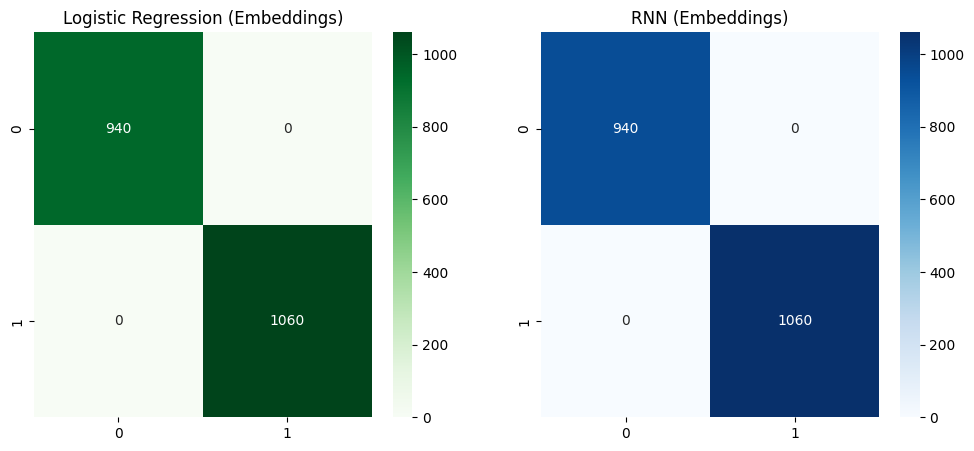

In [ ]:
#prediction by logistic regression model
lr_preds = lr_model.predict(X_test)

#prediction by rnn model
rnn_preds = (rnn_model.predict(X_test_rnn) > 0.5).astype("int32")

print("--- Logistic Regression Report ---")
print(classification_report(y_test, lr_preds))

print("--- RNN Model Report ---")
print(classification_report(y_test, rnn_preds))

# Heatmap Comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
sns.heatmap(confusion_matrix(y_test, lr_preds), annot=True, fmt='d', ax=ax1, cmap='Greens')
ax1.set_title('Logistic Regression (Embeddings)')
sns.heatmap(confusion_matrix(y_test, rnn_preds), annot=True, fmt='d', ax=ax2, cmap='Blues')
ax2.set_title('RNN (Embeddings)')
plt.show()

### Step 8: Sentiment & Final Test
Let's test both our models on a brand new email!

In [ ]:
my_email = "You won a free holiday! Click here now!"
my_email_clean = clean_simple(my_email)

# 1. Create Embedding
my_embed = embed_model.encode([my_email_clean])

# 2. Logistic Regression Prediction
lr_pred = lr_model.predict(my_embed)

# 3. RNN Prediction (Needs reshape!)
my_embed_rnn = my_embed.reshape((1, 1, 384))
rnn_pred = rnn_model.predict(my_embed_rnn)

# 4. Sentiment
sentiment = TextBlob(my_email).sentiment.polarity

print(f"Email: {my_email}")
print("-" * 20)
print(f"Logistic Prediction: {'SPAM' if lr_pred[0] == 1 else 'HAM'}")
print(f"RNN Prediction     : {'SPAM' if rnn_pred[0][0] > 0.5 else 'HAM'} (Confidence: {rnn_pred[0][0]:.2f})")
print(f"Sentiment Score     : {sentiment:.2f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Email: You won a free holiday! Click here now!
--------------------
Logistic Prediction: SPAM
RNN Prediction     : SPAM (Confidence: 0.78)
Sentiment Score     : 0.62


## Step 9: Save the model for protyping

In [ ]:
import joblib
# 1. Save the Logistic Regression Model
joblib.dump(lr_model, 'spam_lr_model.joblib')

# 2. Save the RNN Model
rnn_model.save('spam_rnn_model.h5')

print("Models Saved Successfully!")
print("Files generated: spam_lr_model.joblib, spam_rnn_model.h5")